# Visualisatiot of scors in map

In [ ]:
!pip install geopandas
!pip install pydeck

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import geopandas as gpd
import pydeck as pdk

import requests
import json
from io import BytesIO

import file_processing_EIT
import file_processing_NMT

Visualisation of legend.

In [62]:
def color_map_func(x):
    hex_colors = ['#FF004D', '#A93759', '#7C4343', '#8D683E', '#2D922A', '#09FF00']
    rgb_colors = [tuple(int(h[i:i+2], 16) for i in (1, 3, 5)) for h in hex_colors]

    n = len(rgb_colors) - 1
    x_scaled = x * n
    i = min(int(x_scaled), n - 1)
    ratio = x_scaled - i

    r = int(rgb_colors[i][0] + (rgb_colors[i + 1][0] - rgb_colors[i][0]) * ratio)
    g = int(rgb_colors[i][1] + (rgb_colors[i + 1][1] - rgb_colors[i][1]) * ratio)
    b = int(rgb_colors[i][2] + (rgb_colors[i + 1][2] - rgb_colors[i][2]) * ratio)

    return (r / 255.0, g / 255.0, b / 255.0)

def plot_legend(min_score, max_score):
    gradient = np.linspace(0, 1, 256).reshape(1, -1)
    colors = [color_map_func(x) for x in np.linspace(0, 1, 256)]
    cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors)

    fig, ax = plt.subplots(figsize=(6, 1.0))
    ax.imshow(gradient, aspect='auto', cmap=cmap)
    ax.set_title("Average Score", fontsize=10, pad=10)
    ax.set_yticks([])

    ticks_pos = np.linspace(0, 255, 5)
    tick_labels = [f"{min_score + (max_score - min_score) * (pos / 255):.1f}" for pos in ticks_pos]

    ax.set_xticks(ticks_pos)
    ax.set_xticklabels(tick_labels)
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_label_position('bottom')

    plt.subplots_adjust(left=0.05, right=0.95, top=0.75, bottom=0.3)
    plt.show()

Function for drawing a map.

In [63]:
def ukraine_map(df):
    url = "https://raw.githubusercontent.com/org-scn-design-studio-community/sdkcommunitymaps/master/geojson/Europe/Ukraine-regions.json"
    response = requests.get(url, verify=False)
    gdf = gpd.read_file(BytesIO(response.content))

    gdf["name"] = gdf["NAME_1"]
    gdf = gdf.merge(df, left_on="name", right_on="EORegName", how="left")

    data_for_scaling = gdf[~gdf['NAME_1'].isin(['Crimea'])]
    min_score = data_for_scaling['Average Score'].min()
    max_score = data_for_scaling['Average Score'].max()
    score_range = max_score - min_score

    geojson = json.loads(gdf.to_json())

    for feature in geojson['features']:
        props = feature['properties']
        score = props['Average Score'] or min_score
        props['color'] = [
            int(255 * (1 - (score - min_score)/score_range)),
            int(255 * ((score - min_score)/score_range)),
            100
        ]
        props['elevation'] = (props['count_of_students'] or 0) / 100

    layer = pdk.Layer(
        "GeoJsonLayer",
        data=geojson,
        get_fill_color="properties.color",
        get_line_color=[0, 0, 0],
        line_width_min_pixels=1,
        stroked=True,
        filled=True,
        extruded=True,
        wireframe=True,
        get_elevation="properties.elevation",
        elevation_scale=100, # height of the area
        pickable=True
    )

    view_state = pdk.ViewState(
        latitude=49.0,
        longitude=31.5,
        zoom=4.7,
        pitch=50,
        bearing=9
    )

    tooltip = {
        "html": """
        <b>{NAME_1}</b><br/>
        Average score: <b>{Average Score}</b><br/>
        Number of students: <b>{count_of_students}</b>
        """,
        "style": {
            "backgroundColor": "gay",
            "color": "white",
            "fontFamily": '"Helvetica Neue", Arial',
            "zIndex": "10000"
        }
    }

    map_3d = pdk.Deck(
        layers=[layer],
        initial_view_state=view_state,
        tooltip=tooltip,
        map_style="light"
    )
    plot_legend(min_score, max_score)
    return map_3d.show()

Mapping for translation the names of the regions into English according to the content of the
JSON file describing the map of Ukraine.

Some areas are not in the dataset itself. Therefore, we add them manually and assign a score of np.nan.

In [64]:
mapping = {
    "Черкаська область": "Cherkasy", "Чернігівська область": "Chernihiv", "Чернівецька область": "Chernivtsi",
    "Дніпропетровська область": "Dnipropetrovs'k", "Донецька область": "Donets'k", "Івано-Франківська область": "Ivano-Frankivs'k",
    "Харківська область": "Kharkiv", "Херсонська область": "Kherson", "Хмельницька область": "Khmel'nyts'kyy",
    "Київська область": "Kiev", "Кіровоградська область": "Kirovohrad", "Луганська область": "Luhans'k",
    "Львівська область": "L'viv", "Миколаївська область": "Mykolayiv", "Одеська область": "Odessa",
    "Полтавська область": "Poltava", "Рівненська область": "Rivne", "Сумська область": "Sumy",
    "Тернопільська область": "Ternopil'", "Вінницька область": "Vinnytsya", "Волинська область": "Volyn",
    "Закарпатська область": "Transcarpathia", "Запорізька область": "Zaporizhzhya", "Житомирська область": "Zhytomyr",
    "м.Київ" : "Kiev City"
}

missing_data = pd.DataFrame({
    'EORegName': ['Crimea'],
    'Average Score': np.nan
})

## EIT results

Group by EIT preparation region, and sort by descending average score.

And display the results

/Users/hanna/venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'raw.githubusercontent.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


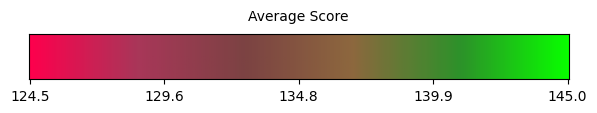

In [65]:
eit = file_processing_EIT.EIT

eit_by_region = eit.groupby('EORegName').agg(
    median_score=('Average Score', 'median'),
    count_of_students=('EORegName', 'count')
).reset_index()
eit_by_region.rename(columns={
    'median_score': 'Average Score'
}, inplace=True)

eit_by_region = eit_by_region.sort_values('Average Score', ascending=False)
eit_by_region['EORegName'] = eit_by_region['EORegName'].map(mapping)

eit_by_region = pd.concat([eit_by_region, missing_data], ignore_index=True)

title_eit = "EIT Results Median in Ukrainian Schools: A Regional Map"
ukraine_map(eit_by_region)

In [66]:
eit_by_region

,EORegName,Average Score,count_of_students
0,Kiev City,145.0,83351.0
1,L'viv,142.5,72565.0
2,Kharkiv,139.0,60792.0
3,Kiev,137.0,39093.0
4,Volyn,137.0,32632.0
5,Cherkasy,136.5,27716.0
6,Sumy,136.5,25003.0
7,Chernihiv,135.0,23577.0
8,Khmel'nyts'kyy,135.0,32936.0
9,Ternopil',135.0,29118.0


## NMT

Also group by region, and sort by descending average score.

And display the results.

/Users/hanna/venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'raw.githubusercontent.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


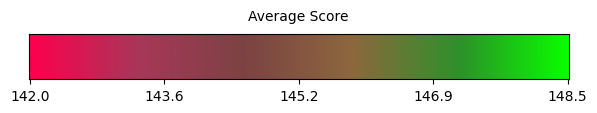

In [67]:
nmt = file_processing_NMT.NMT

nmt_by_region = nmt.groupby('EORegName').agg(
    median_score=('Average Score', 'median'),
    count_of_students=('EORegName', 'count')
).reset_index()
nmt_by_region.rename(columns={
    'median_score': 'Average Score'
}, inplace=True)

nmt_by_region = nmt_by_region.sort_values('Average Score', ascending=False)
nmt_by_region['EORegName'] = nmt_by_region['EORegName'].map(mapping)

nmt_by_region = pd.concat([nmt_by_region, missing_data], ignore_index=True)

title_nmt = "NMT Results Median in Ukrainian Schools: A Regional Map"
ukraine_map(nmt_by_region)

In [68]:
nmt_by_region

,EORegName,Average Score,count_of_students
0,L'viv,148.5,54498.0
1,Kiev City,148.0,71361.0
2,Luhans'k,146.0,3262.0
3,Kherson,146.0,6765.0
4,Kharkiv,145.0,39241.0
5,Volyn,145.0,24218.0
6,Rivne,144.5,26052.0
7,Ternopil',144.0,20580.0
8,Sumy,144.0,17243.0
9,Ivano-Frankivs'k,144.0,27124.0
